##### 1. Import Libraries

In [1]:

import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 

plt.style.use('fivethirtyeight') # This is a styling option for how plots will appear. 



##### 2. Import Data

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'VoDpj_xHgTyKPD1qw6gn'

In [3]:
data = quandl.get('RATEINF/CPI_USA')

##### 3. Data Wrangling & Cleaning

In [4]:
# Display dataframe first 5 rows
data.head()

,Value
Date,
1913-01-31,9.8
1913-02-28,9.8
1913-03-31,9.8
1913-04-30,9.8
1913-05-31,9.7


In [30]:
# Display Dataframe last 5 rows
data.tail()

,Value
Date,
2021-07-31,273.003
2021-08-31,273.567
2021-09-30,274.310
2021-10-31,276.589
2021-11-30,277.948


In [5]:
# Checking number of rows and columns
data.shape

(1307, 1)

In [6]:
# Checking name of columns
data.columns

Index(['Value'], dtype='object')

In [7]:
# Checking Datatype
type(data)

pandas.core.frame.DataFrame

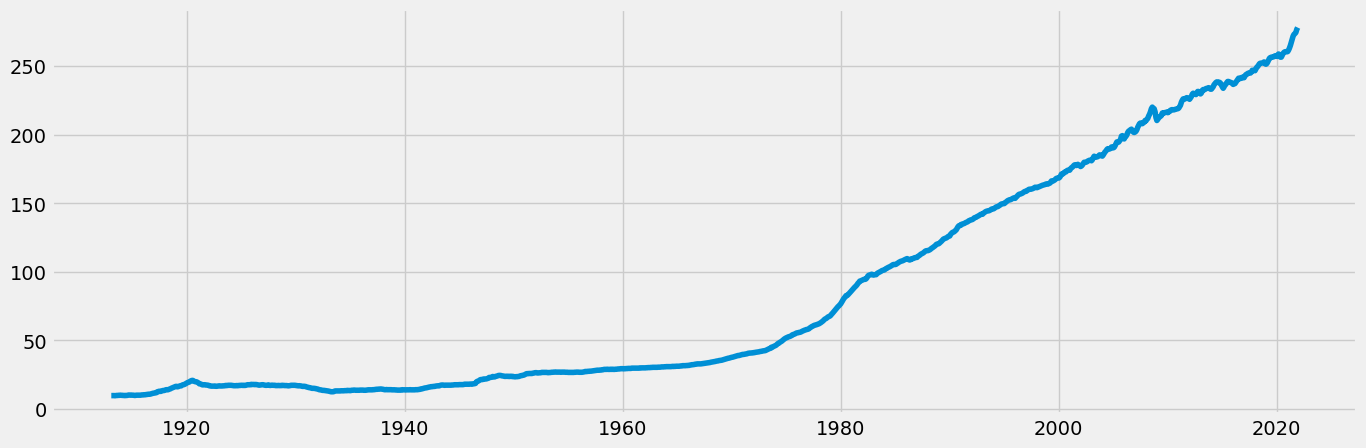

In [8]:
# Plotting the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

##### 4. Creating Subset

I created subset from 1980s to 2021, because this is the period when major economical developments happended, and overall Global circumstances are quite stable and standarized since then

In [9]:
# Resetting index so that I can use the "Date" column as a filter

data_2 = data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,1913-01-31,9.8
1,1913-02-28,9.8
2,1913-03-31,9.8
3,1913-04-30,9.8
4,1913-05-31,9.7


In [12]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2021-11-30')]

In [13]:
data_sub.shape

(502, 2)

In [14]:
data_sub.head()

,Date,Value
804,1980-01-31,77.8
805,1980-02-29,78.9
806,1980-03-31,80.1
807,1980-04-30,81.0
808,1980-05-31,81.8


In [15]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-31,77.8
1980-02-29,78.9
1980-03-31,80.1
1980-04-30,81.0
1980-05-31,81.8


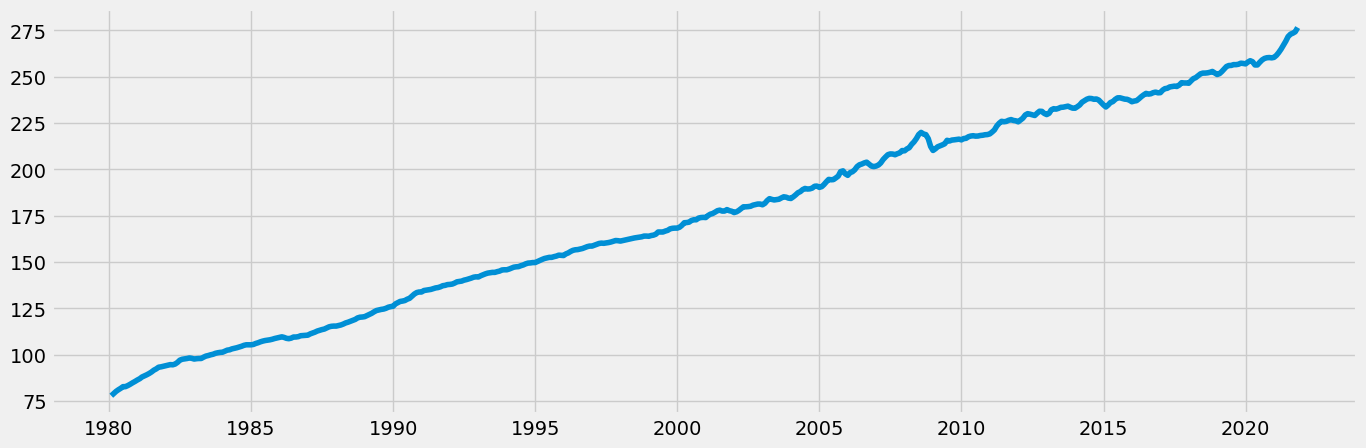

In [16]:
# Plotting the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [17]:
# Check for missing values 

data_sub.isnull().sum() 

Value    0
dtype: int64

In [18]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

29

##### 5. Time Series Analysis and Decomposition 

In [19]:
# Decomposing the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [20]:
# defining a fixed size for all special charts.
from pylab import rcParams 

rcParams['figure.figsize'] = 18, 7

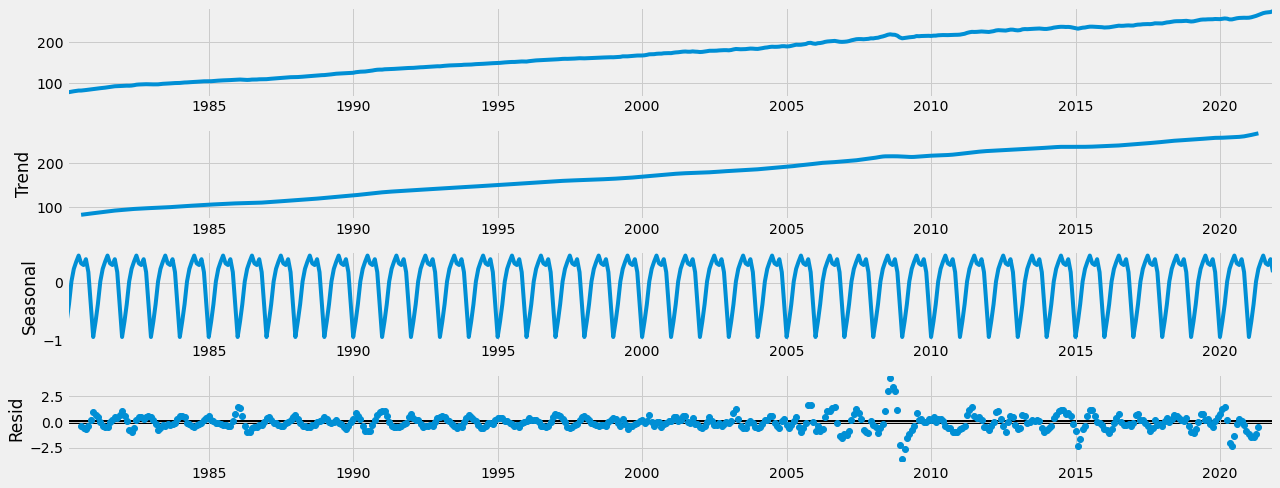

In [21]:
# Ploting the separate components

decomposition.plot()
plt.show()

Here we can see that the level and trend look almost alike that means this data is smoothed data.The trend in the chart is gradually rising in linear fashion since 1985 till 2021 , so we can say that the trend is dominant.Here we can see the seasonality in this dataset with the fluctuation in form of spikey curve at regular interval.The Residual shows that there is not much unexplained noise in this data except around year 2008 & 2009 because of Global financial crisis.We have seasonality in our data but because there is dominant increasing trend over the period , which means that we need to test this data for stationarity before we can forecast it.

##### 6. Test for Stationarity

In [22]:
# Importing adfuller() function, performing Dickey-Fuller Test, and apply test using function on time series

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   0.937018
p-value                          0.993555
Number of Lags Used             13.000000
Number of Observations Used    488.000000
Critical Value (1%)             -3.443821
Critical Value (5%)             -2.867481
Critical Value (10%)            -2.569934
dtype: float64


Here we are using a significance level of 5 % , so lets take the critical value (5%) which is -2.867 , and the test statistic came is 0.93, so this test statistic is way larger than the critical value and p value 0f 0.99 is much higher than the significance level of 0.05, thats means I cannot reject the null hypothesis and this proves that there is unit root present in this data set and this is non stationary data. 

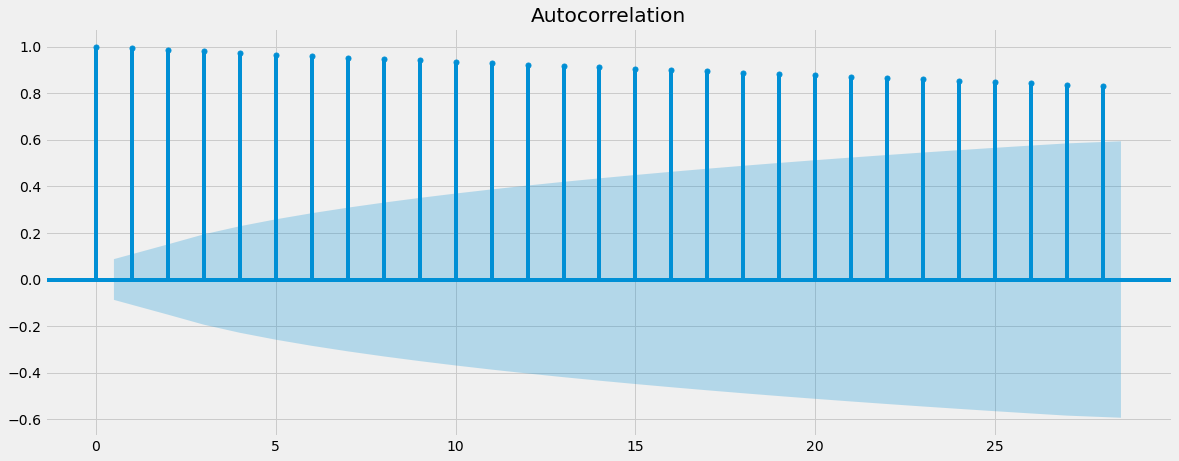

In [23]:
# plotting autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(data_sub)
plt.show()

The autocorrelation shows that almost all the lags are beyond the confidence interval likely indicating the data is non-stationary and this is autocorrelated data. The Dickey-Fuller test was correct in stating the data is non-stationary.

##### 7. Stationarize Data

In [24]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [25]:
data_diff.dropna(inplace = True) # removing the missing values that came about as a result of the differencing. 
# If we do not remove these , we won't be able to run the Dickey-Fuller test

In [26]:
data_diff.columns

Index(['Value'], dtype='object')

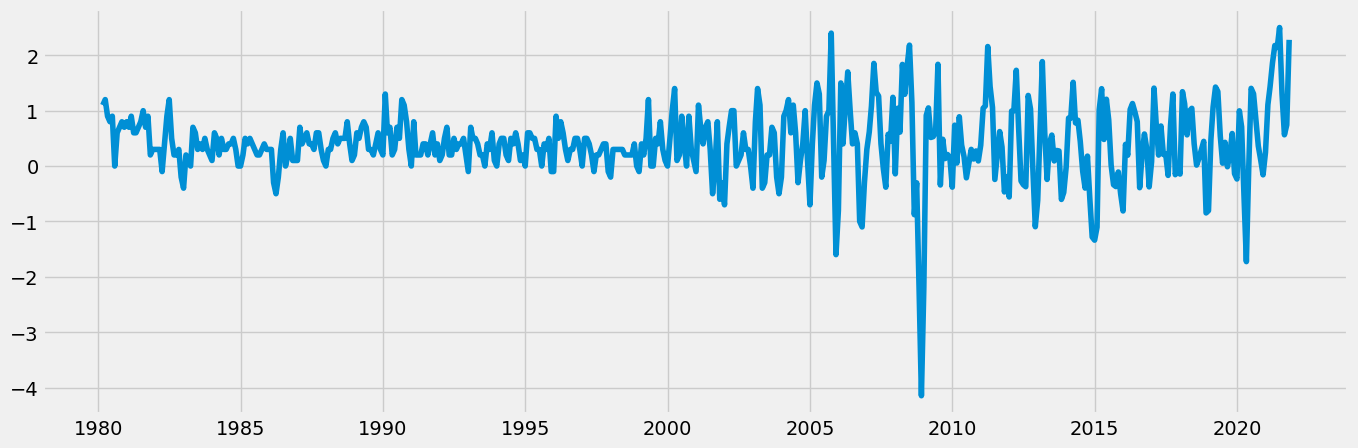

In [27]:
# Checking out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [28]:
# # Performing Dickey-Fuller test
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.648276
p-value                          0.000105
Number of Lags Used             12.000000
Number of Observations Used    488.000000
Critical Value (1%)             -3.443821
Critical Value (5%)             -2.867481
Critical Value (10%)            -2.569934
dtype: float64


After conducting differencing over the dataset, the test-statistic (-4.64) is now smaller than the critical values at 5% (-2.86) and at 10% (-2.56). Based on this the null hypothesis can be rejected and the series is now stationary. The test result is also significant as the p-value is less than 0.05.

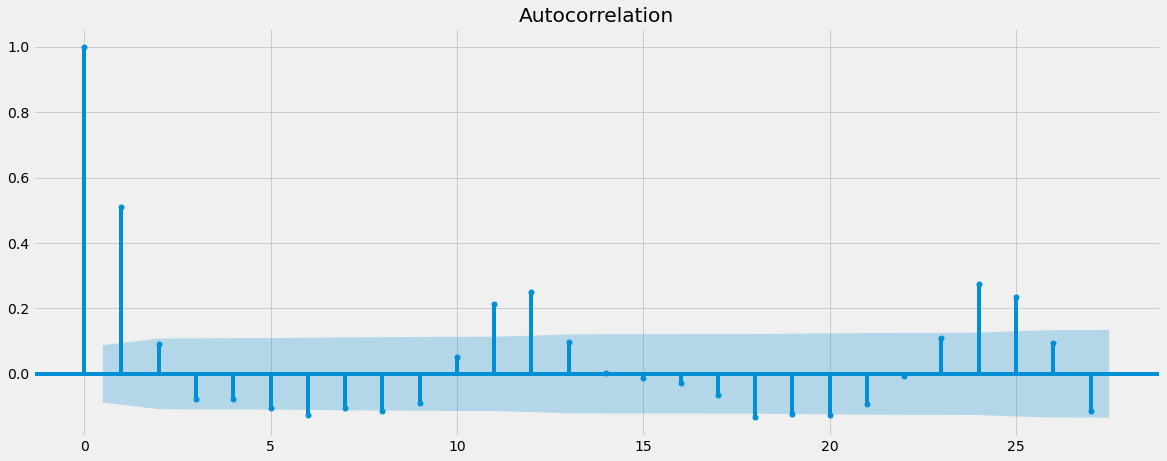

In [29]:
# Displaying autocorrelation
plot_acf(data_diff)
plt.show()

The autocorrelation after differencing is significantly different with very few autocorrelated lags.Now this dataset has only 6 significant lags outside of the confidence interval , which is a number less than 10 so that means second round of differencing is not necessary , but that also means that the stationarity in this data is not very strong.